In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 📘 Three-Factor Hull-White Model – Additive OU Process

The **Hull-White model** is a short-rate interest rate model used in quantitative finance. The **three-factor version** extends the basic model by incorporating three sources of randomness, allowing for a more flexible and realistic modeling of the term structure of interest rates. 

## 🧠 Overview

The additive Ornstein-Uhlenbeck version of the Hull–White model represents the short rate as the sum of multiple independent mean-reverting processes. Each factor follows its own Ornstein-Uhlenbeck dynamic, contributing to the overall behavior of the interest rate. In essence, this three-factor Hull–White model can be viewed as the sum of three correlated one-factor Hull–White processes.

This approach is analytically tractable, allowing for closed-form solutions for zero-coupon bond prices and efficient Monte Carlo simulations. It is particularly useful in environments where speed and simplicity are essential, such as pricing vanilla interest rate derivatives or performing scenario analysis. However, since the short rate is normally distributed, it can take negative values, which may not be desirable in all market conditions.

---

## 🧮 Model Structure

The short rate $r(t)$ is modeled as the sum of three independent Ornstein-Uhlenbeck processes:

$
r(t) = x(t) + y(t) + z(t)
$

Each factor evolves according to the following stochastic differential equations (SDEs):

$
\begin{aligned}
dx(t) &= a_1 (\mu_1 - x(t)) dt + \sigma_1 dW_1(t) \\
dy(t) &= a_2 (\mu_2 - y(t)) dt + \sigma_2 dW_2(t) \\
dz(t) &= a_3 (\mu_3 - z(t)) dt + \sigma_3 dW_3(t)
\end{aligned}
$

Where:
- $ a_i $: Mean-reversion speed of factor $i$
- $ \mu_i $: Long-term mean levels of factor $i$
- $ \sigma_i $: Volatility of factor $i$
- $ W_i(t) $: Brownian motion (possibly correlated)

---

## 🔗 Correlation Structure

The Brownian motions $ W_1, W_2, W_3 $ are correlated. The correlation matrix is:

$
\begin{bmatrix}
1 & \rho_{12} & \rho_{13} \\
\rho_{12} & 1 & \rho_{23} \\
\rho_{13} & \rho_{23} & 1
\end{bmatrix}
$

To simulate correlated random variables, **Cholesky decomposition** is applied to this matrix.

---

## 🎲 Monte Carlo Simulation

The model uses **Monte Carlo simulation** to generate multiple paths of the short rate:

1. **Initialize** the factors $ x_0, y_0, z_0 $
2. **For each time step**:
   - Generate 3 correlated normal random variables
   - Update each factor using its SDE
   - Compute the short rate $ r(t) = x(t) + y(t) + z(t) $
3. **Repeat** for multiple paths

---

## 📊 Output

- The simulation returns all paths of the short rate.
- The `mean_path` function computes the **average final short rate** across all simulated paths.



In [21]:
class HullWhite3Factor:
    def __init__(self, a1, a2, a3, mu_1, mu_2, mu_3, sigma1, sigma2, sigma3):
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.mu_1 = mu_1
        self.mu_2 = mu_2
        self.mu_3 = mu_3
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.sigma3 = sigma3

    def MC_model(self, num_of_paths, iterations, x0, y0, z0, rho12, rho13, rho23):
        dt = 0.01
        all_paths = []

        # Correlation matrix and Cholesky decomposition
        corr_matrix = np.array([
            [1.0, rho12, rho13],
            [rho12, 1.0, rho23],
            [rho13, rho23, 1.0]
        ])
        L = np.linalg.cholesky(corr_matrix)

        np.random.seed(10)  # Set seed once for reproducibility

        for i in range(num_of_paths):
            x = [x0]
            y = [y0]
            z = [z0]
            r = [x0 + y0 + z0]

            for j in range(iterations):
                z_uncorr = np.random.normal(0, 1, 3)
                z_corr = np.dot(L, z_uncorr)

                dx = self.a1 * ( self.mu_1 - x[-1]) * dt + self.sigma1 * np.sqrt(dt) * z_corr[0]
                dy =  self.a2 * ( self.mu_2 - y[-1]) * dt + self.sigma2 * np.sqrt(dt) * z_corr[1]
                dz =  self.a3 * ( self.mu_3 - z[-1]) * dt + self.sigma3 * np.sqrt(dt) * z_corr[2]

                x.append(x[-1] + dx)
                y.append(y[-1] + dy)
                z.append(z[-1] + dz)
                r.append(x[-1] + y[-1] + z[-1])

            all_paths.append(r)

        return all_paths

    def mean_path(self, all_paths):
        final_rates = [path[-1] for path in all_paths]
        return np.mean(final_rates)


Mean of final interest rates across all paths: 0.020726


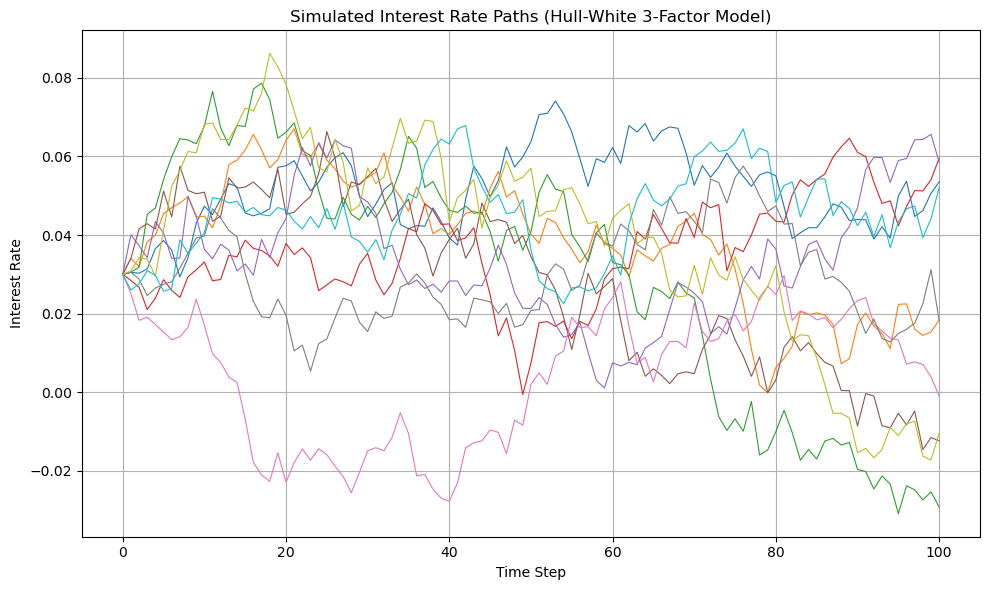

In [25]:
# Instantiate the model
model = HullWhite3Factor(a1=0.3, a2=0.7, a3=1.1, mu_1=0.002, mu_2=0.03, mu_3=0.004, sigma1=0.015, sigma2=0.025, sigma3=0.035)

# Simulate paths
simulated_paths = model.MC_model(
    num_of_paths=10,
    iterations=100,
    x0=0.01,
    y0=0.01,
    z0=0.01,
    
    rho12=0.2,
    rho13=0.1,
    rho23=0.3
)

# Calculate mean of final interest rates
mean_final_rate = model.mean_path(simulated_paths)
print(f"Mean of final interest rates across all paths: {mean_final_rate:.6f}")

# Plot the simulated paths
plt.figure(figsize=(10, 6))
plt.xlabel('Time Step')
plt.ylabel('Interest Rate')
plt.title('Simulated Interest Rate Paths (Hull-White 3-Factor Model)')

for path in simulated_paths:
    plt.plot(path, linewidth=0.8)

plt.grid(True)
plt.tight_layout()
plt.show()
